# 风格迁移

这个也是动手学深度学习首页图片。

![pic](./d2l_pic.png)

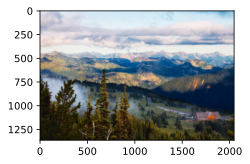

In [ ]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from IPython import display

# 辅助函数
def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    plt.rcParams['figure.figsize'] = figsize

def try_gpu(i=0):
    """返回第i个GPU设备，如果不存在则返回CPU"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes]
        else:
            self.axes = self.axes.flatten()
        self.config_axes = lambda: self._set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def _set_axes(self, axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置matplotlib的轴"""
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

set_figsize()
content_img = Image.open('../img/rainier.jpg')
plt.imshow(content_img)

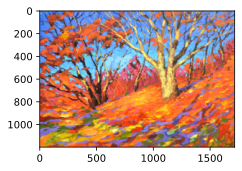

In [ ]:
stype_img = Image.open('../img/autumn-oak.jpg')
plt.imshow(stype_img)

In [3]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    return transforms(img).unsqueeze(0)

In [ ]:
def postprocess(img):
    img = img[0].to(rgb_std.device)
    # 先将(img)的shape从(C,H,W)变为(H,W,C)，这样可以方便进行后续的逐通道反归一化
    # permute(1,2,0) 是把原本第0轴(C)移到最后，使数据格式变成(H,W,C)
    img = img.permute(1,2,0)
    # 反归一化，乘回标准差，加上均值
    img = img * rgb_std + rgb_mean
    # 限制像素范围在[0,1]
    img = torch.clamp(img, 0, 1)
    # 再把shape从(H,W,C)变回(C,H,W)，以便ToPILImage能接受
    img = img.permute(2, 0, 1)
    return torchvision.transforms.ToPILImage()(img)

In [5]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

/Users/haoyiwen/miniforge3/envs/d2l/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/haoyiwen/miniforge3/envs/d2l/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/haoyiwen/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [6]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [7]:
net = nn.Sequential(*[
    pretrained_net.features[i] for i in range(max(content_layers + style_layers)+1)
])

In [8]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [9]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape=image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(stype_img, image_shape).to(device)
    _, style_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, style_Y

In [10]:
def content_loss(Y_hat, Y):
    # 这里的detach()的作用是切断Y与之前计算图的联系，防止梯度反向传播到Y（内容图像的特征），
    # 只让梯度作用于Y_hat（合成图像的特征），这是计算损失时常见的做法。
    return torch.square(Y_hat - Y.detach()).mean()

In [12]:
def gram(X):
    """
    gram函数用于计算输入特征图X的Gram矩阵。
    Gram矩阵表示的是不同通道的特征之间的相关性（风格特征），
    在神经风格迁移中用来衡量风格的相似性。
    计算方法是先将特征拉平成二维(num_channels, n)，
    然后计算X与其转置的乘积（即相关性），再除以总元素数进行归一化。
    """
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

In [13]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [ ]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [ ]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [16]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.rand(*img_shape))
    
    def forward(self):
        return self.weight

In [17]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.AdamW(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [ ]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram
        )
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

In [ ]:
device,image_shape = try_gpu(), (300, 450)
net=net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y,styles_Y,  device, 0.3, 500, 50)